# Analyzing EURO-CORDEX Climate Indicators

We will open the climdex catalog and make a plot of all available `TG` indices for historical and scenario time periods. We use a dask scheduler to speed up the processing. This notebook is loosely based on the [CMIP6 global temperature pangeo example](http://gallery.pangeo.io/repos/pangeo-gallery/cmip6/global_mean_surface_temp.html).

In [1]:
from matplotlib import pyplot as plt
import xarray as xr
import numpy as np
import dask
from dask.diagnostics import progress
from tqdm.autonotebook import tqdm 
import intake
import fsspec
import seaborn as sns
import pandas as pd
import xclim

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

/tmp/ipykernel_10006/766847821.py:6: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
from dask.distributed import Client
client = Client()
client

distributed.diskutils - INFO - Found stale lock file and directory '/mnt/lustre01/pf/zmaw/g300046/python/notebooks/dask-worker-space/worker-7nyeyzzc', purging
distributed.diskutils - INFO - Found stale lock file and directory '/mnt/lustre01/pf/zmaw/g300046/python/notebooks/dask-worker-space/worker-4cx_p7zr', purging
distributed.diskutils - INFO - Found stale lock file and directory '/mnt/lustre01/pf/zmaw/g300046/python/notebooks/dask-worker-space/worker-s4hxw0v9', purging
distributed.diskutils - INFO - Found stale lock file and directory '/mnt/lustre01/pf/zmaw/g300046/python/notebooks/dask-worker-space/worker-fn5ixhz0', purging
distributed.diskutils - INFO - Found stale lock file and directory '/mnt/lustre01/pf/zmaw/g300046/python/notebooks/dask-worker-space/worker-gddxswf0', purging
distributed.diskutils - INFO - Found stale lock file and directory '/mnt/lustre01/pf/zmaw/g300046/python/notebooks/dask-worker-space/worker-a47p0052', purging
distributed.diskutils - INFO - Found stale loc

<Client: 'tcp://127.0.0.1:43471' processes=8 threads=48, memory=60.94 GiB>

## Access data

Now we can open the catalog file and make a quick overview of the content...

In [3]:
import intake
%matplotlib
url = "/mnt/lustre02/work/ch0636/eddy/pool/intake-esm_catalogues/climdexCORDEX.json"
cat = intake.open_esm_datastore(url)
cat

Using matplotlib backend: <object object at 0x2aaf49760e90>


In [4]:
# check out which indices are available...
cat.unique()['variable_id']

{'count': 26,
 'values': ['FDD',
  'R10mm',
  'ID',
  'HI',
  'CHDX30',
  'SU',
  'DD',
  'DSPx',
  'SU30',
  'HD17',
  'RR95p',
  'R20mm',
  'R25mm',
  'GD5',
  'TG',
  'RRm',
  'R5mm',
  'RR1',
  'FD',
  'SQI',
  'DSP',
  'RR99p',
  'R15mm',
  'FG',
  'TR',
  'CWB']}

In [5]:
cat.unique()['version']

{'count': 2,
 'values': ['Climate Data Operators version 1-9-8 (https://mpimet-mpg-de/cdo)',
  'climdex-v2-0']}

Now let's get a subset of the data. We want the `TG` index and for all experiment ids.

In [6]:
pd.set_option('display.max_rows', None)
#version = 'Climate Data Operators version 1-9-8 (https://mpimet-mpg-de/cdo)'
version = 'climdex-v2-0'
expts = ['historical', 'rcp26', 'rcp45', 'rcp85']
# require_all_on means we want only those models for which all experiment ids are available.
subset = cat.search(variable_id='TG', frequency='year', version=version, require_all_on='source_id')

subset.df.groupby(["source_id", "driving_model_id", "institution_id", "experiment_id"]
                 )["experiment_id"].nunique()

source_id                     driving_model_id       institution_id  experiment_id
CLMcom-BTU-CCLM4-8-17         MPI-M-MPI-ESM-LR       GERICS          rcp26            1
CLMcom-CCLM4-8-17             CCCma-CanESM2          GERICS          rcp85            1
                              CNRM-CERFACS-CNRM-CM5  GERICS          rcp45            1
                                                                     rcp85            1
                              ECMWF-ERAINT           GERICS          evaluation       1
                              ICHEC-EC-EARTH         GERICS          rcp26            1
                                                                     rcp45            1
                                                                     rcp85            1
                              MIROC-MIROC5           GERICS          rcp26            1
                                                                     rcp85            1
                              MOHC-Ha

In [7]:
dset_dict = subset.to_dataset_dict(cdf_kwargs = {"use_cftime": True, "chunks": {}})


--> The keys in the returned dictionary of datasets are constructed as follows:
	'CORDEX_domain.institution_id.source_id.driving_model_id.experiment_id.member_id.table_id'


In [8]:
ds = dset_dict["EUR-11.GERICS.GERICS-REMO2015.IPSL-IPSL-CM5A-LR.rcp26.r1i1p1.day"]
#ds = dset_dict['EUR-11.GERICS.SMHI-RCA4.ICHEC-EC-EARTH.rcp85.r12i1p1.day']
ds

<xarray.Dataset>
Dimensions:                     (time: 152, bnds: 2, rlat: 412, rlon: 424, vertices: 4)
Coordinates:
  * time                        (time) object 1949-07-02 12:00:00 ... 2100-07...
    lon                         (rlat, rlon) float32 dask.array<chunksize=(412, 424), meta=np.ndarray>
    lat                         (rlat, rlon) float32 dask.array<chunksize=(412, 424), meta=np.ndarray>
  * rlon                        (rlon) float64 -28.38 -28.27 ... 18.04 18.16
  * rlat                        (rlat) float64 -23.38 -23.27 ... 21.72 21.84
    height                      float64 ...
Dimensions without coordinates: bnds, vertices
Data variables:
    time_bnds                   (time, bnds) object dask.array<chunksize=(152, 2), meta=np.ndarray>
    lon_bnds                    (rlat, rlon, vertices) float32 dask.array<chunksize=(412, 424, 4), meta=np.ndarray>
    lat_bnds                    (rlat, rlon, vertices) float32 dask.array<chunksize=(412, 424, 4), meta=np.ndarray>
    rotated_latitude_longitude  int32 ...
    TG                          (time, rlat, rlon) float32 dask.array<chunksize=(152, 412, 424), meta=np.ndarray>
Attributes: (12/42)
    history:                        Tue May 04 10:41:05 2021: cdo -O -f nc4 -...
    source:                         GERICS-REMO2015
    institution:                    Helmholtz-Zentrum Geesthacht, Climate Ser...
    Conventions:                    CF-1.4
    institute_id:                   GERICS
    experiment_id:                  historical
    ...                             ...
    ci_frequency:                   year
    ci_timerange_index:             1949-2100
    ci_timerange_source:            19480102-21001231
    ci_package_reference:           Climate Data Operators version 1.9.8 (htt...
    intake_esm_varname:             ['TG']
    intake_esm_dataset_key:         EUR-11.GERICS.GERICS-REMO2015.IPSL-IPSL-C...

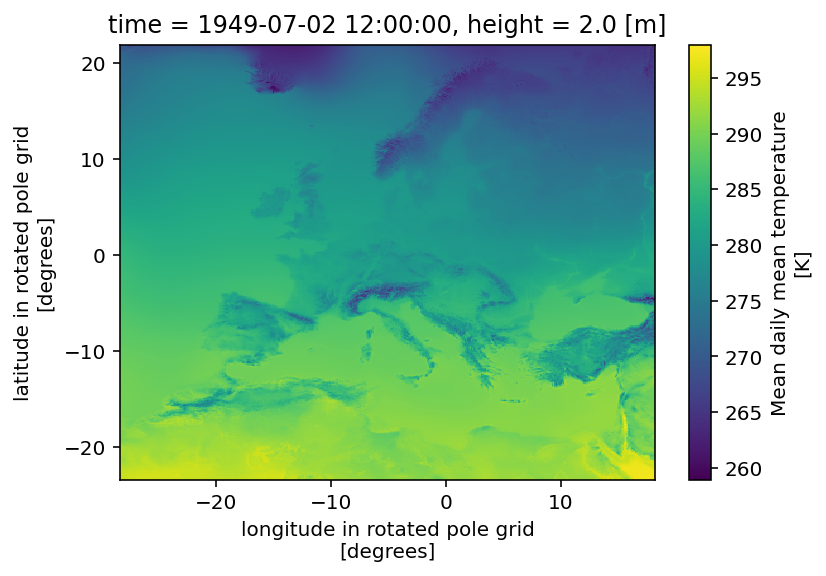

In [9]:
%matplotlib inline
ds.TG.isel(time=0).plot()

## Data preparation

The CORDEX datasets are not really all that CF compliant as they should be. They also have different calendars and coordinates. We have to [prepare the data](https://en.wikipedia.org/wiki/Data_preparation) to make the different models comparable. Lets first define some helper functions.

In [10]:
# experimentel cordex module that deals with CORDEX datasets
from cordex import preprocessing as preproc
from cftime import datetime as dt

def drop_all_bounds(ds):
    """Drops boundaries"""
    drop_vars = [vname for vname in ds
                 if (('bounds') in vname ) or ('bnds') in vname]
    return ds.drop(drop_vars).squeeze(drop=True)

def get_experiment_from_id(dset_id):
    """Return the experiment id from the dataset id"""
    return dset_id.split(".")[4]

Now, we do the actual data alignment. We drop boundaries, filter rotated pole models, set coordinates and use one common calendar.

In [11]:
# drop boundaries since they have different names in the different models.
dset_dict_preproc = {key: drop_all_bounds(preproc.rename_cordex(ds)) for key, ds in dset_dict.items()}

# only use rotated pole models for now.
rotated = {key: ds for key, ds in dset_dict_preproc.items() if preproc.get_grid_mapping_name(ds) == 'rotated_latitude_longitude'}

# replace coordinates with official archive specifications.
rotated = {key: preproc.replace_coords(ds) for key, ds in rotated.items()}

# replace calendars with standard gregorian since we only use monthly or yearly frequencies anyway.
for dset_id, ds in rotated.items():
    #ds['time'] = [dt(date.year, 1, 1) for date in ds.time.values]
    ds['time'] = [date.year for date in ds.time.values]

In [12]:
ds = rotated['EUR-11.GERICS.KNMI-RACMO22E.CNRM-CERFACS-CNRM-CM5.rcp26.r1i1p1.day']
ds

<xarray.Dataset>
Dimensions:                     (time: 151, rlat: 412, rlon: 424)
Coordinates:
  * time                        (time) int64 1950 1951 1952 ... 2098 2099 2100
  * rlon                        (rlon) float64 -28.38 -28.27 ... 18.05 18.16
  * rlat                        (rlat) float64 -23.38 -23.27 ... 21.73 21.84
    lon                         (rlat, rlon) float64 -10.06 -9.964 ... 64.96
    lat                         (rlat, rlon) float64 21.99 22.03 ... 66.75 66.69
Data variables:
    rotated_latitude_longitude  int32 ...
    height                      float64 ...
    TG                          (time, rlat, rlon) float32 dask.array<chunksize=(151, 412, 424), meta=np.ndarray>
Attributes: (12/39)
    history:                        Tue May 04 06:52:44 2021: cdo -O -f nc4 -...
    institution:                    Royal Netherlands Meteorological Institute
    Conventions:                    CF-1.4
    contact:                        Erik van Meijgaard, KNMI, Regional Climat...
    experiment:                     Historical run
    experiment_id:                  historical
    ...                             ...
    ci_frequency:                   year
    ci_timerange_index:             1950-2100
    ci_timerange_source:            19500101-21001231
    ci_package_reference:           Climate Data Operators version 1.9.8 (htt...
    intake_esm_varname:             ['TG']
    intake_esm_dataset_key:         EUR-11.GERICS.KNMI-RACMO22E.CNRM-CERFACS-...

Now, we sort the datasets depending on their `experiment_id` attribute. This is useful, since there are many more `rcp85` than `rcp26` or `rcp45` datasets available and we can handle those separately.

In [16]:
from collections import defaultdict
dsets_sorted = defaultdict(dict)

for dset_id, ds in rotated.items():
    dsets_sorted[get_experiment_from_id(dset_id)][dset_id] = ds

# count numbers
print(dsets_sorted.keys())
for exp_id, dsets in dsets_sorted.items():
    print('found {} datasets for {}'.format(len(dsets), exp_id))
print('found {} datasets in total'.format(sum([len(dsets) for dsets in dsets_sorted.values()])))

dict_keys(['evaluation', 'rcp45', 'rcp26', 'rcp85'])
found 9 datasets for evaluation
found 23 datasets for rcp45
found 26 datasets for rcp26
found 65 datasets for rcp85
found 123 datasets in total


So we have now sorted out 123 datasets, basically one for each rcm model. It would be a pain having always to loop over all those datasets. We can combine those datasets into ensembles to make computations easier and efficient.

### Create ensemble datasets

We will create one dataset per scnenario.

In [18]:
ensemble_dict = {}

for exp_id, dsets in dsets_sorted.items():
    print(exp_id)
    ensemble = xr.concat(list(dsets_sorted[exp_id].values()), dim='dset_id')
    ensemble['dset_id'] = list(dsets_sorted[exp_id].keys())
    ensemble_dict[exp_id] = ensemble

evaluation


ValueError: 'height' is not present in all datasets.

Ok, there was a problem with combining the datasets because they have different values for the `height` coordinate. Let's investigate this:

In [19]:
for dset_id, ds in dsets_sorted['rcp85'].items():
    if 'height' in ds:
        print(dset_id, ds.height.values)
    else:
        print(dset_id, 'unknown')

EUR-11.GERICS.DMI-HIRHAM5.MPI-M-MPI-ESM-LR.rcp85.r1i1p1.day 2.0
EUR-11.GERICS.IPSL-WRF381P.MOHC-HadGEM2-ES.rcp85.r1i1p1.day unknown
EUR-11.GERICS.DMI-HIRHAM5.NCC-NorESM1-M.rcp85.r1i1p1.day 2.0
EUR-11.GERICS.KNMI-RACMO22E.NCC-NorESM1-M.rcp85.r1i1p1.day 2.0
EUR-11.GERICS.GERICS-REMO2015.MOHC-HadGEM2-ES.rcp85.r1i1p1.day 2.0
EUR-11.GERICS.KNMI-RACMO22E.MPI-M-MPI-ESM-LR.rcp85.r1i1p1.day 2.0
EUR-11.GERICS.SMHI-RCA4.MPI-M-MPI-ESM-LR.rcp85.r1i1p1.day 2.0
EUR-11.GERICS.CLMcom-CCLM4-8-17.MIROC-MIROC5.rcp85.r1i1p1.day 2.0
EUR-11.GERICS.DMI-HIRHAM5.IPSL-IPSL-CM5A-MR.rcp85.r1i1p1.day 2.0
EUR-11.GERICS.MPI-CSC-REMO2009.MPI-M-MPI-ESM-LR.rcp85.r1i1p1.day 2.0
EUR-11.GERICS.CLMcom-ETH-COSMO-crCLIM-v1-1.MPI-M-MPI-ESM-LR.rcp85.r2i1p1.day 2.0
EUR-11.GERICS.GERICS-REMO2015.IPSL-IPSL-CM5A-MR.rcp85.r1i1p1.day 2.0
EUR-11.GERICS.DMI-HIRHAM5.ICHEC-EC-EARTH.rcp85.r12i1p1.day 2.0
EUR-11.GERICS.CLMcom-CCLM4-8-17.MPI-M-MPI-ESM-LR.rcp85.r1i1p1.day 2.0
EUR-11.GERICS.MOHC-HadREM3-GA7-05.MPI-M-MPI-ESM-LR.rcp85.r1i1p1.da

We can see that there are different values for `height`. Some datasets don't even define that coordinate. However, we can just ignore this by setting the `compat`, `coords` and `data_vars` keyword appropriately in `xr.concat`. Still, it's important to keep in mind that we ignored these inconsistencies.

In [20]:
ensemble_dict = {}

for exp_id, dsets in dsets_sorted.items():
    ensemble = xr.concat([ds.TG.to_dataset() for ds in list(dsets_sorted[exp_id].values())], dim='dset_id', compat='override', coords='minimal')
    ensemble['dset_id'] = list(dsets_sorted[exp_id].keys())
    ensemble_dict[exp_id] = ensemble

Now, we are only left with three ensemble datasets that we can now easily analyze. Note, that we have made the dataset ids which where keys in our dictionary before into a coordinate of a dataset ids. That means that we can do *all* analysis now for *all* models without having to think about the inconsistencies anymore and let xarray do the [parallelization an vectorization](https://examples.dask.org/xarray.html). We can also now do cross model computations easily (e.g. min, max, mean, etc...).

In [21]:
ensemble_dict.keys()

for exp_id, ens in ensemble_dict.items():
    print('found {} datasets for {}'.format(len(ens.dset_id), exp_id))

found 9 datasets for evaluation
found 23 datasets for rcp45
found 26 datasets for rcp26
found 65 datasets for rcp85


In [22]:
ensemble_dict['rcp26']

<xarray.Dataset>
Dimensions:  (time: 152, rlon: 424, rlat: 412, dset_id: 26)
Coordinates:
  * time     (time) int64 1949 1950 1951 1952 1953 ... 2096 2097 2098 2099 2100
  * rlon     (rlon) float64 -28.38 -28.27 -28.16 -28.05 ... 17.94 18.05 18.16
  * rlat     (rlat) float64 -23.38 -23.27 -23.16 -23.05 ... 21.62 21.73 21.84
    lon      (rlat, rlon) float64 -10.06 -9.964 -9.864 ... 64.55 64.76 64.96
    lat      (rlat, rlon) float64 21.99 22.03 22.07 22.11 ... 66.81 66.75 66.69
  * dset_id  (dset_id) <U69 'EUR-11.GERICS.KNMI-RACMO22E.MPI-M-MPI-ESM-LR.rcp...
Data variables:
    TG       (dset_id, time, rlat, rlon) float32 dask.array<chunksize=(1, 152, 412, 424), meta=np.ndarray>

e.g., convert to `degC` is as easy as

In [23]:
rcp26_degC = ensemble_dict['rcp26'] - 273.5

## Data analysis

In [24]:
from matplotlib import pyplot as plt

Let's do some basic analysis to show what we can do now with the ensemble datasets, e.g., let's plot a quick overview of our complete datasets. We will compute a rolling spatial mean for the change in each scenario and plot those to get an overview.

Let's define some useful functions:

In [25]:
def change(ds, ref=slice("1970","2000")):
    ref = ds.sel(time=ref).mean(dim='time')
    return ds - ref

def rolling_mean(ds):
    # simple weighting approach for non-uniform grid cell sizes
    weights = np.cos(np.deg2rad(ds.rlat))
    return ds.rolling(time=30, center=True).mean().weighted(weights).mean(dim=('rlon', 'rlat'))

Now, we compute rolling spatial means for all scenarios:

In [29]:
scen = xr.DataArray(list(ensemble_dict.keys()), dims='scen')
rolling = xr.concat([rolling_mean(change(ds)) for ds in ensemble_dict.values()], dim=scen)
rolling

<xarray.Dataset>
Dimensions:  (time: 152, dset_id: 123, scen: 4)
Coordinates:
  * time     (time) int64 1949 1950 1951 1952 1953 ... 2096 2097 2098 2099 2100
  * dset_id  (dset_id) <U81 'EUR-11.GERICS.CLMcom-BTU-CCLM4-8-17.MPI-M-MPI-ES...
  * scen     (scen) <U10 'evaluation' 'rcp45' 'rcp26' 'rcp85'
Data variables:
    TG       (scen, dset_id, time) float64 dask.array<chunksize=(1, 3, 63), meta=np.ndarray>

We have been [lazy](https://xarray.pydata.org/en/stable/user-guide/dask.html) for now. Let's do the actual computation before plotting.

In [30]:
rolling_ = rolling.compute() # check out the dask dashboard here to see the execution of the delayed computations...

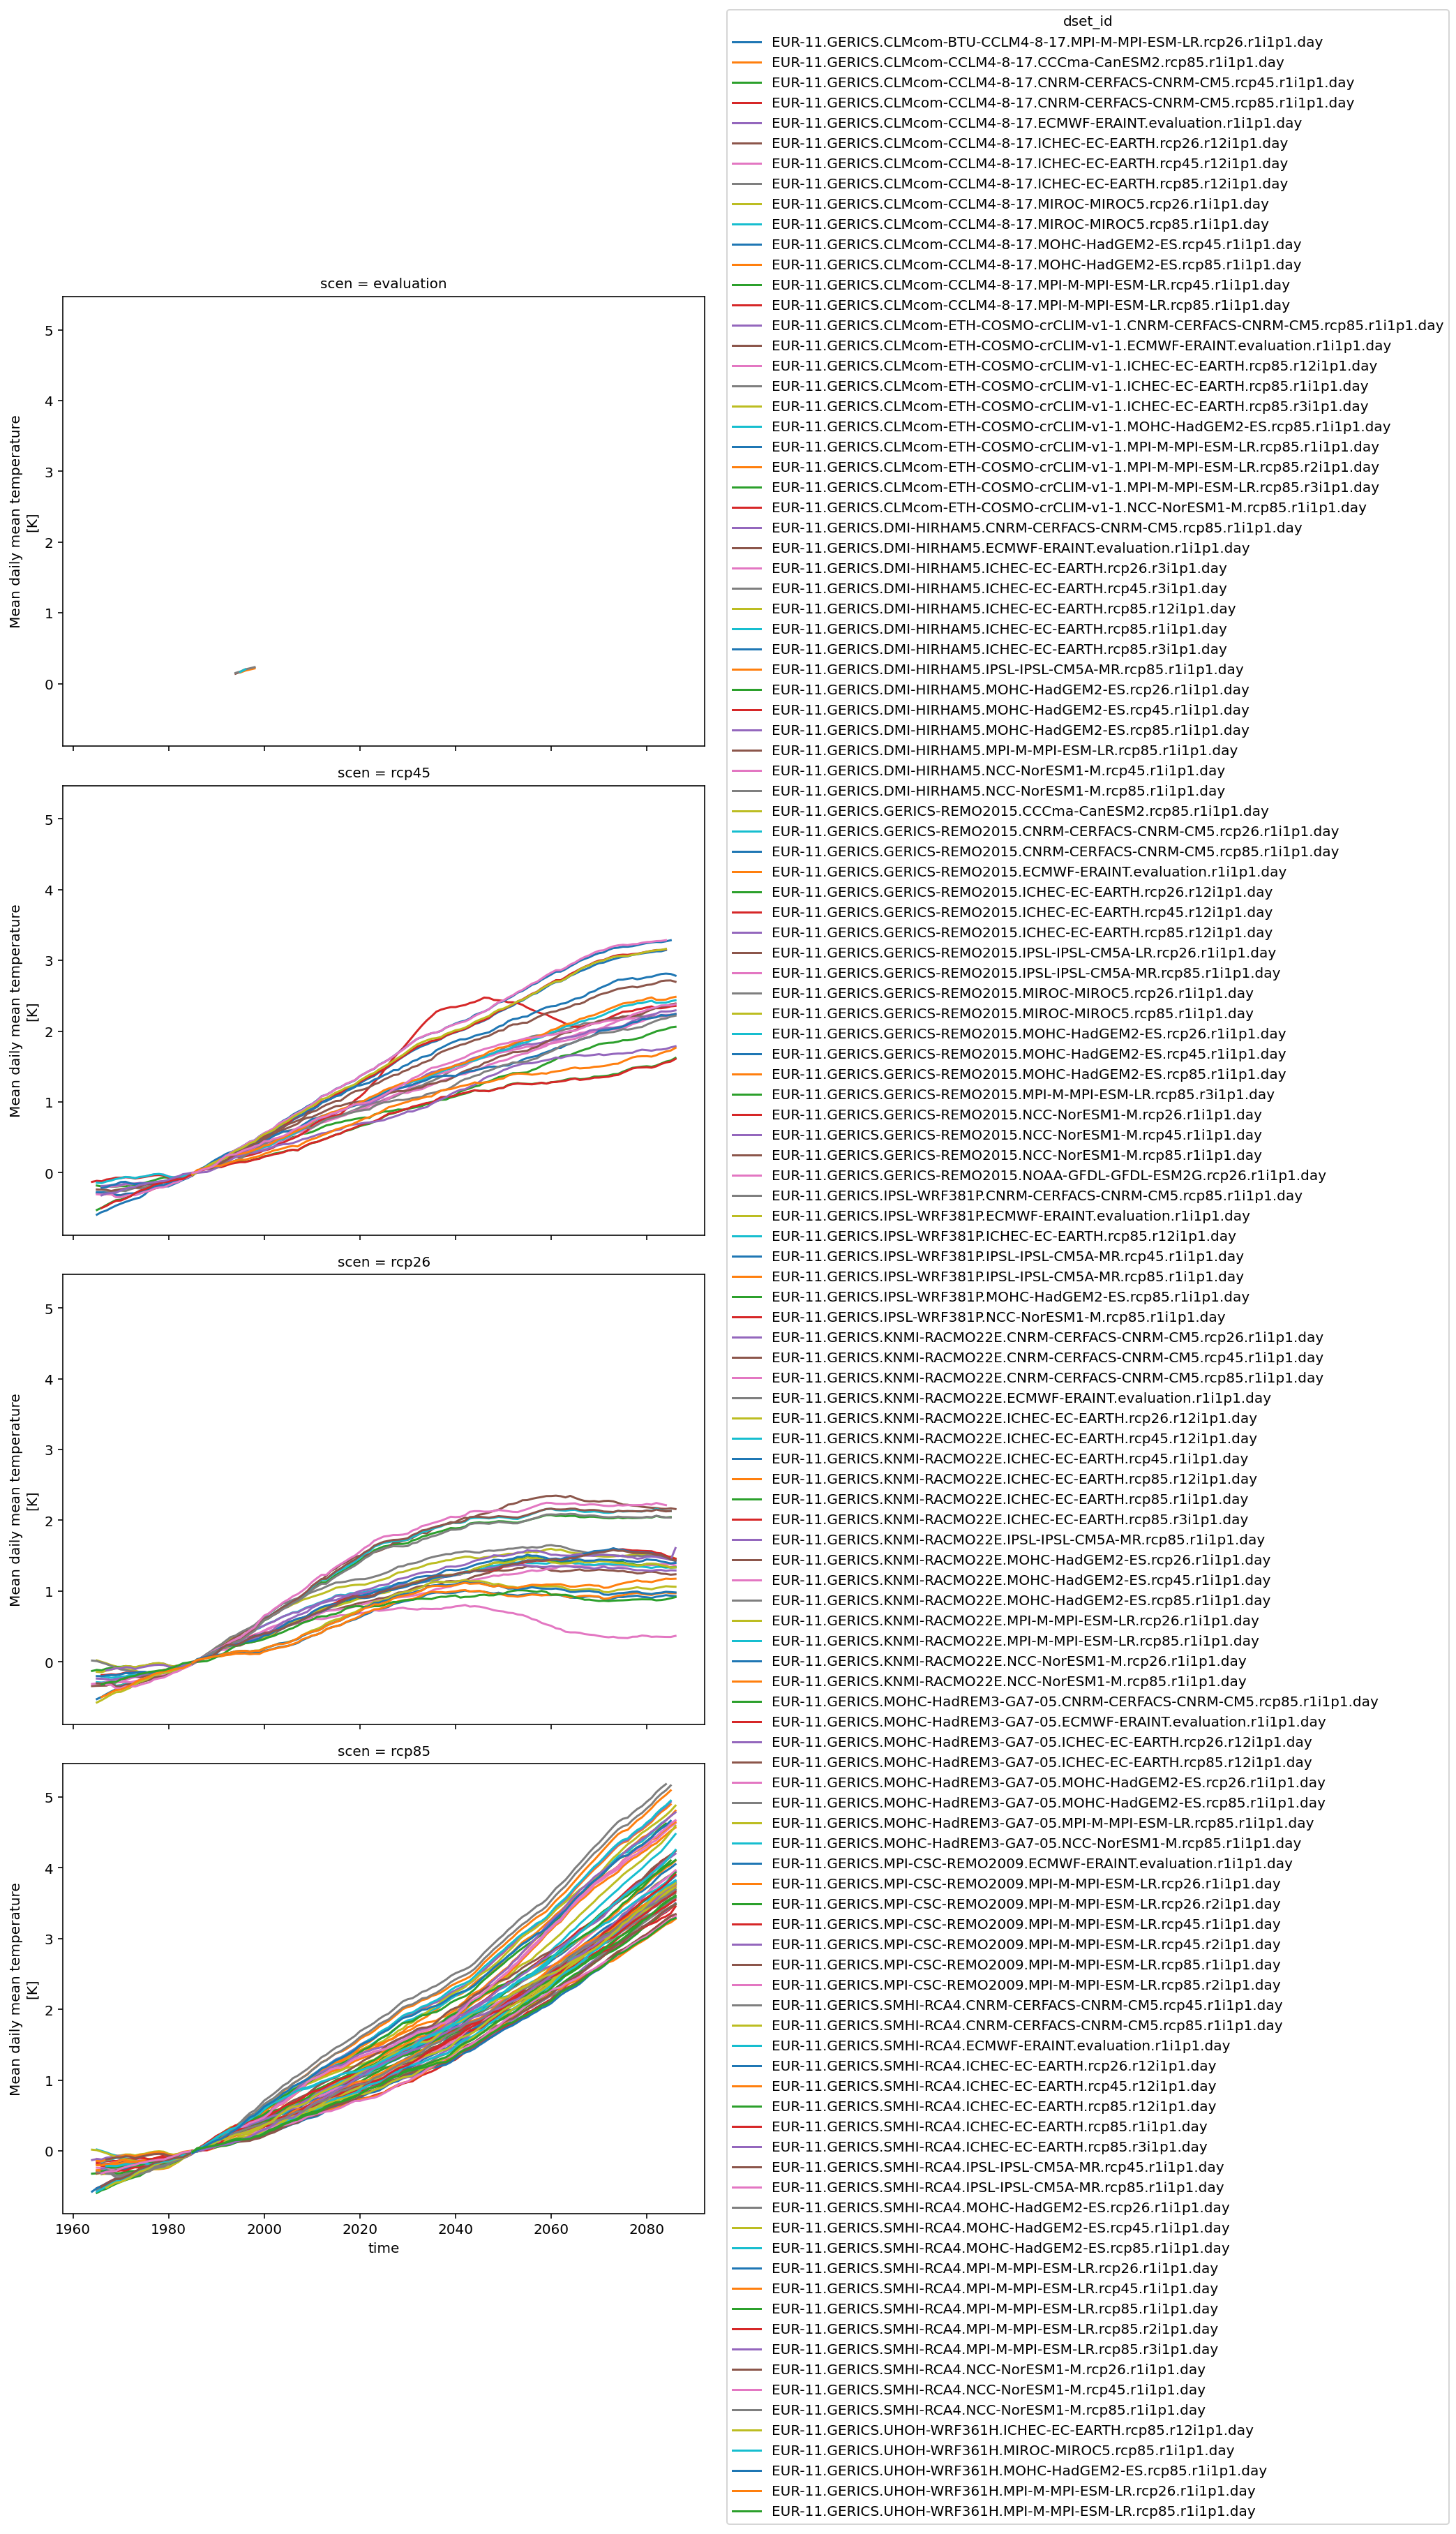

In [31]:
#from matplotlib import pyplot as plt
fig = rolling_.TG.plot(hue='dset_id', figsize=(8,20), row='scen')

### Statistical plots with pandas

In [62]:
import seaborn as sns
sns.set_theme()
sns.set_theme(style="whitegrid", palette="pastel")
sns.set(rc={'figure.figsize':(30,20)})

In [39]:
rolling_.nbytes / 1.e6

0.6395

In [131]:
df = rolling_.to_dataframe().reset_index()
df.head(10)

time                                            dset_id        scen  TG
0  1949  EUR-11.GERICS.CLMcom-BTU-CCLM4-8-17.MPI-M-MPI-...  evaluation NaN
1  1949  EUR-11.GERICS.CLMcom-BTU-CCLM4-8-17.MPI-M-MPI-...       rcp45 NaN
2  1949  EUR-11.GERICS.CLMcom-BTU-CCLM4-8-17.MPI-M-MPI-...       rcp26 NaN
3  1949  EUR-11.GERICS.CLMcom-BTU-CCLM4-8-17.MPI-M-MPI-...       rcp85 NaN
4  1949  EUR-11.GERICS.CLMcom-CCLM4-8-17.CCCma-CanESM2....  evaluation NaN
5  1949  EUR-11.GERICS.CLMcom-CCLM4-8-17.CCCma-CanESM2....       rcp45 NaN
6  1949  EUR-11.GERICS.CLMcom-CCLM4-8-17.CCCma-CanESM2....       rcp26 NaN
7  1949  EUR-11.GERICS.CLMcom-CCLM4-8-17.CCCma-CanESM2....       rcp85 NaN
8  1949  EUR-11.GERICS.CLMcom-CCLM4-8-17.CNRM-CERFACS-C...  evaluation NaN
9  1949  EUR-11.GERICS.CLMcom-CCLM4-8-17.CNRM-CERFACS-C...       rcp45 NaN

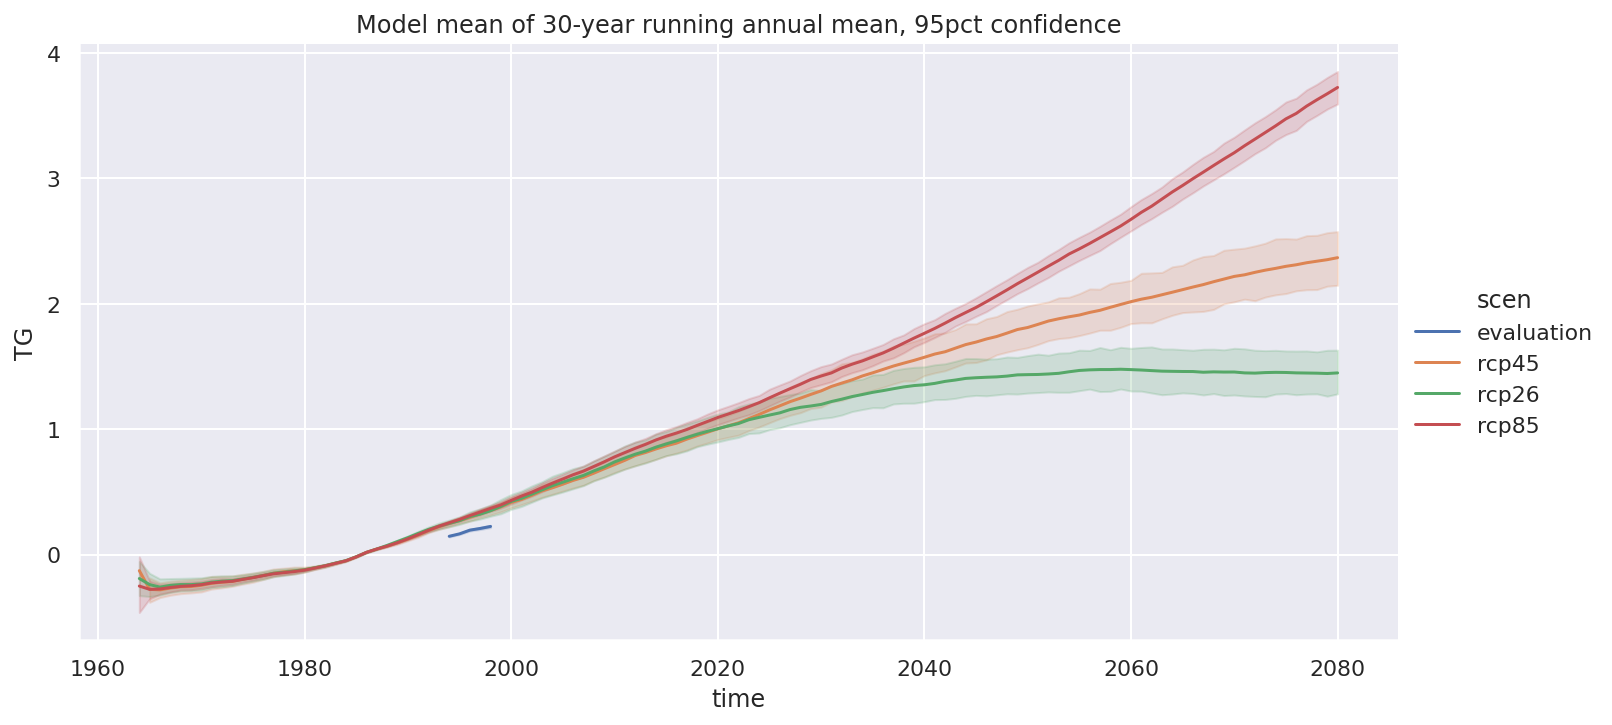

In [63]:
sns.set_theme(style="whitegrid", palette="pastel")
sns.set(rc={'figure.figsize':(30,20)})
palette ={"evaluation": "C0", "rcp26": "C2", "rcp45": "C1", "rcp85": "C3"}
g = sns.relplot(data=df[(df['time']>=1950) & (df['time']<=2080)],
            x="time", y="TG", hue="scen",
            kind="line", ci=95, aspect=2, palette=palette);
g.set(title="Model mean of 30-year running annual mean, 95pct confidence")

### Advanced plotting with matplotlib

In [406]:
# A list of country/zones that are going to be highlighted
#HIGHLIGHTS = ["MPI-M-MPI-ESM-LR", "MIROC-MIROC5"]
HIGHLIGHTS = ["GERICS-REMO2015", "MPI-CSC-REMO2009"]

In [132]:
df_plot = df[df['scen'] == 'rcp85']

In [133]:
xmin = 1980; xmax=2100
ymin = -0.5; ymax=6

In [134]:
# Shades of gray
GREY10 = "#1a1a1a"
GREY30 = "#4d4d4d"
GREY40 = "#666666"
GREY50 = "#7f7f7f"
GREY60 = "#999999"
GREY75 = "#bfbfbf"
GREY91 = "#e8e8e8"
GREY98 = "#fafafa"

# Colors used to shade countries
COLOR_SCALE = [
    "#7F3C8D", 
    "#11A579", 
    "#3969AC", 
    "#F2B701", 
    "#E73F74", 
    "#80BA5A", 
    "#E68310",
    "#E68310",
    GREY50     
]

from matplotlib.cm import get_cmap

name = "Set3"
cmap = get_cmap(name)  # type: matplotlib.colors.ListedColormap
COLOR_SCALE = cmap.colors 


# Vertical lines every 10 years
VLINES = np.arange(xmin, xmax+10, 10)

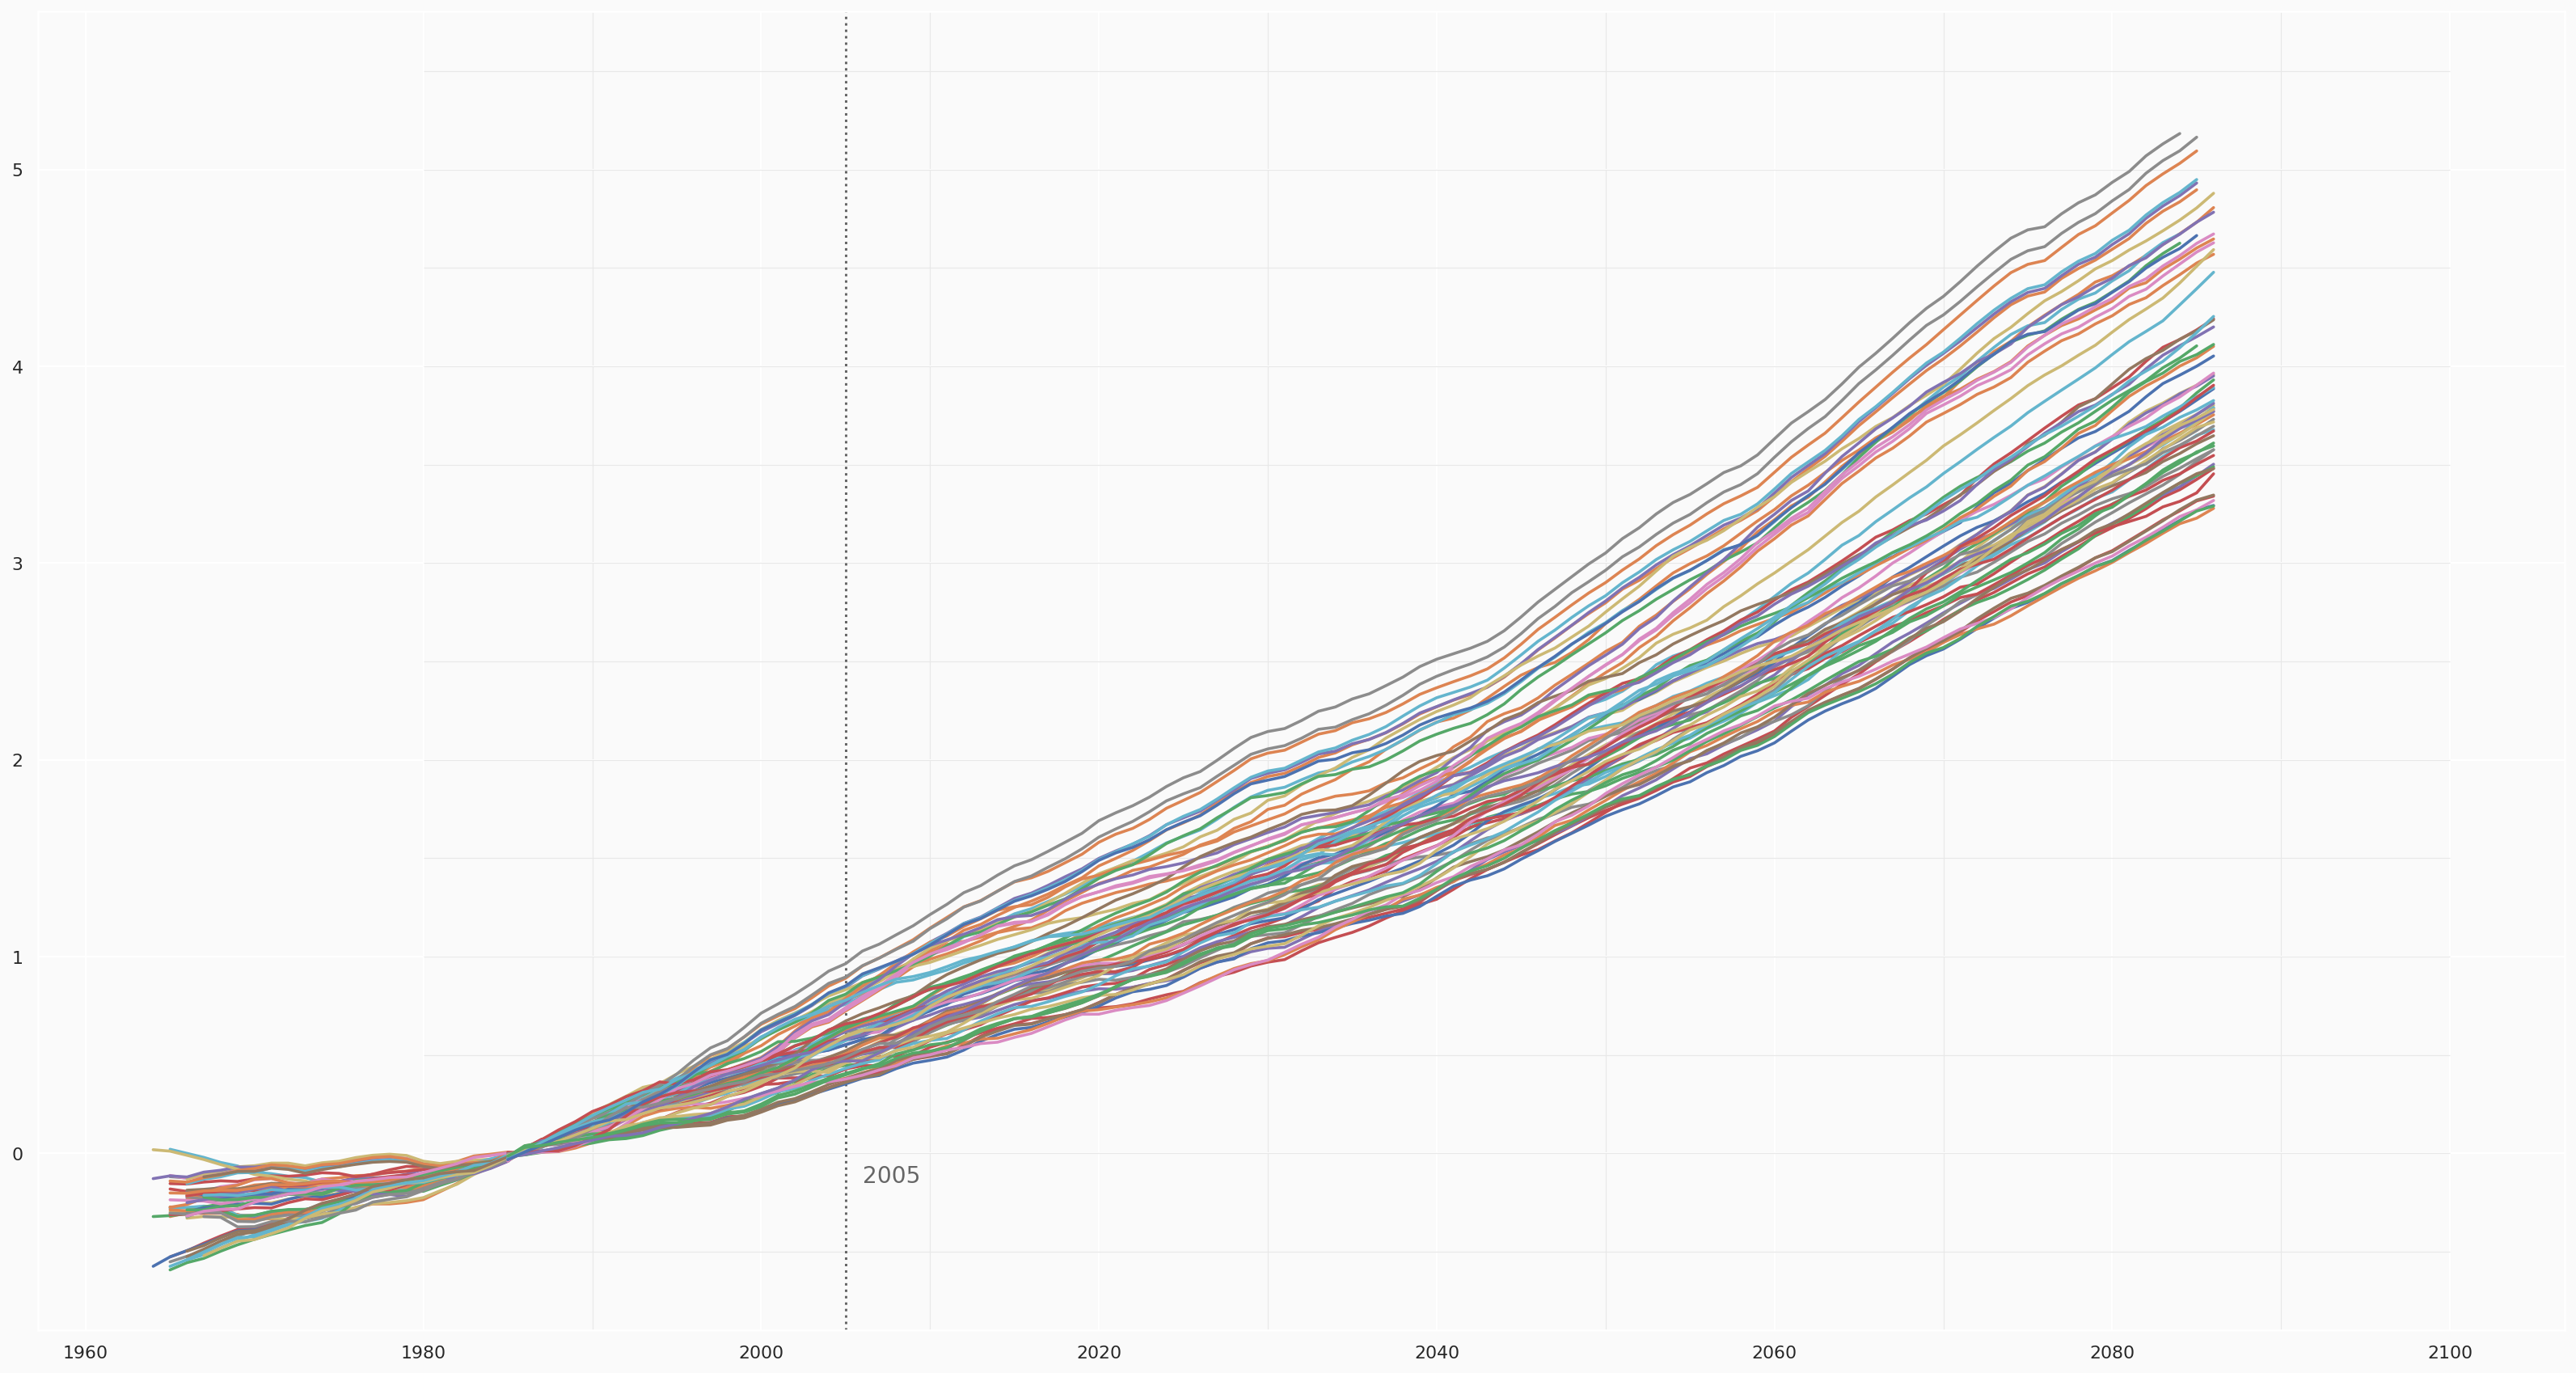

In [139]:
# Initialize layout ----------------------------------------------

fig, ax = plt.subplots(figsize = (28, 15))

# Background color
fig.patch.set_facecolor(GREY98)
ax.set_facecolor(GREY98)

# Vertical lines used as scale reference
for h in VLINES:
    ax.axvline(h, color=GREY91, lw=0.6, zorder=0)

# Horizontal lines
ax.hlines(y=np.arange(ymin, ymax, 0.5), xmin=xmin, xmax=xmax, color=GREY91, lw=0.6)

# Darker horizontal line at y=0
ax.hlines(y=0, xmin=xmax, xmax=xmax, color=GREY60, lw=0.8)

# Vertical like at x = 2008
ax.axvline(2005, color=GREY40, ls="dotted")

# Annotations indicating the meaning of the vertical line
ax.text(2006, ymin+0.35, "2005", fontname="Montserrat", 
        fontsize=14, fontweight=500, color=GREY40, ha="left")

#g = sns.lineplot(x="time", y="TG", hue='dset_id', data=, ax=ax)

for idx, group in enumerate(df_plot.groupby('dset_id')):
    df = group[1]#.reset_index()
    #print(df)
    #data = ds.TG.squeeze(drop=True).to_dataframe().reset_index()
    #color = COLOR_SCALE[idx]
    ax.plot('time', 'TG', lw=1.8, data=df)


In [140]:
# First, adjust axes limits so annotations fit in the plot
ax.set_xlim(1970, 2080)
ax.set_ylim(-0.8, 6)

# Positions
LABEL_YSHIFT = [
    -0.45,  
    -0.15,  
    0.5,    
    -1.7,   
    -0.75,  
    0.15,   
    -1.05,  
    2.1     
]

x_start = 2100
x_end = 2103
PAD = 0.1

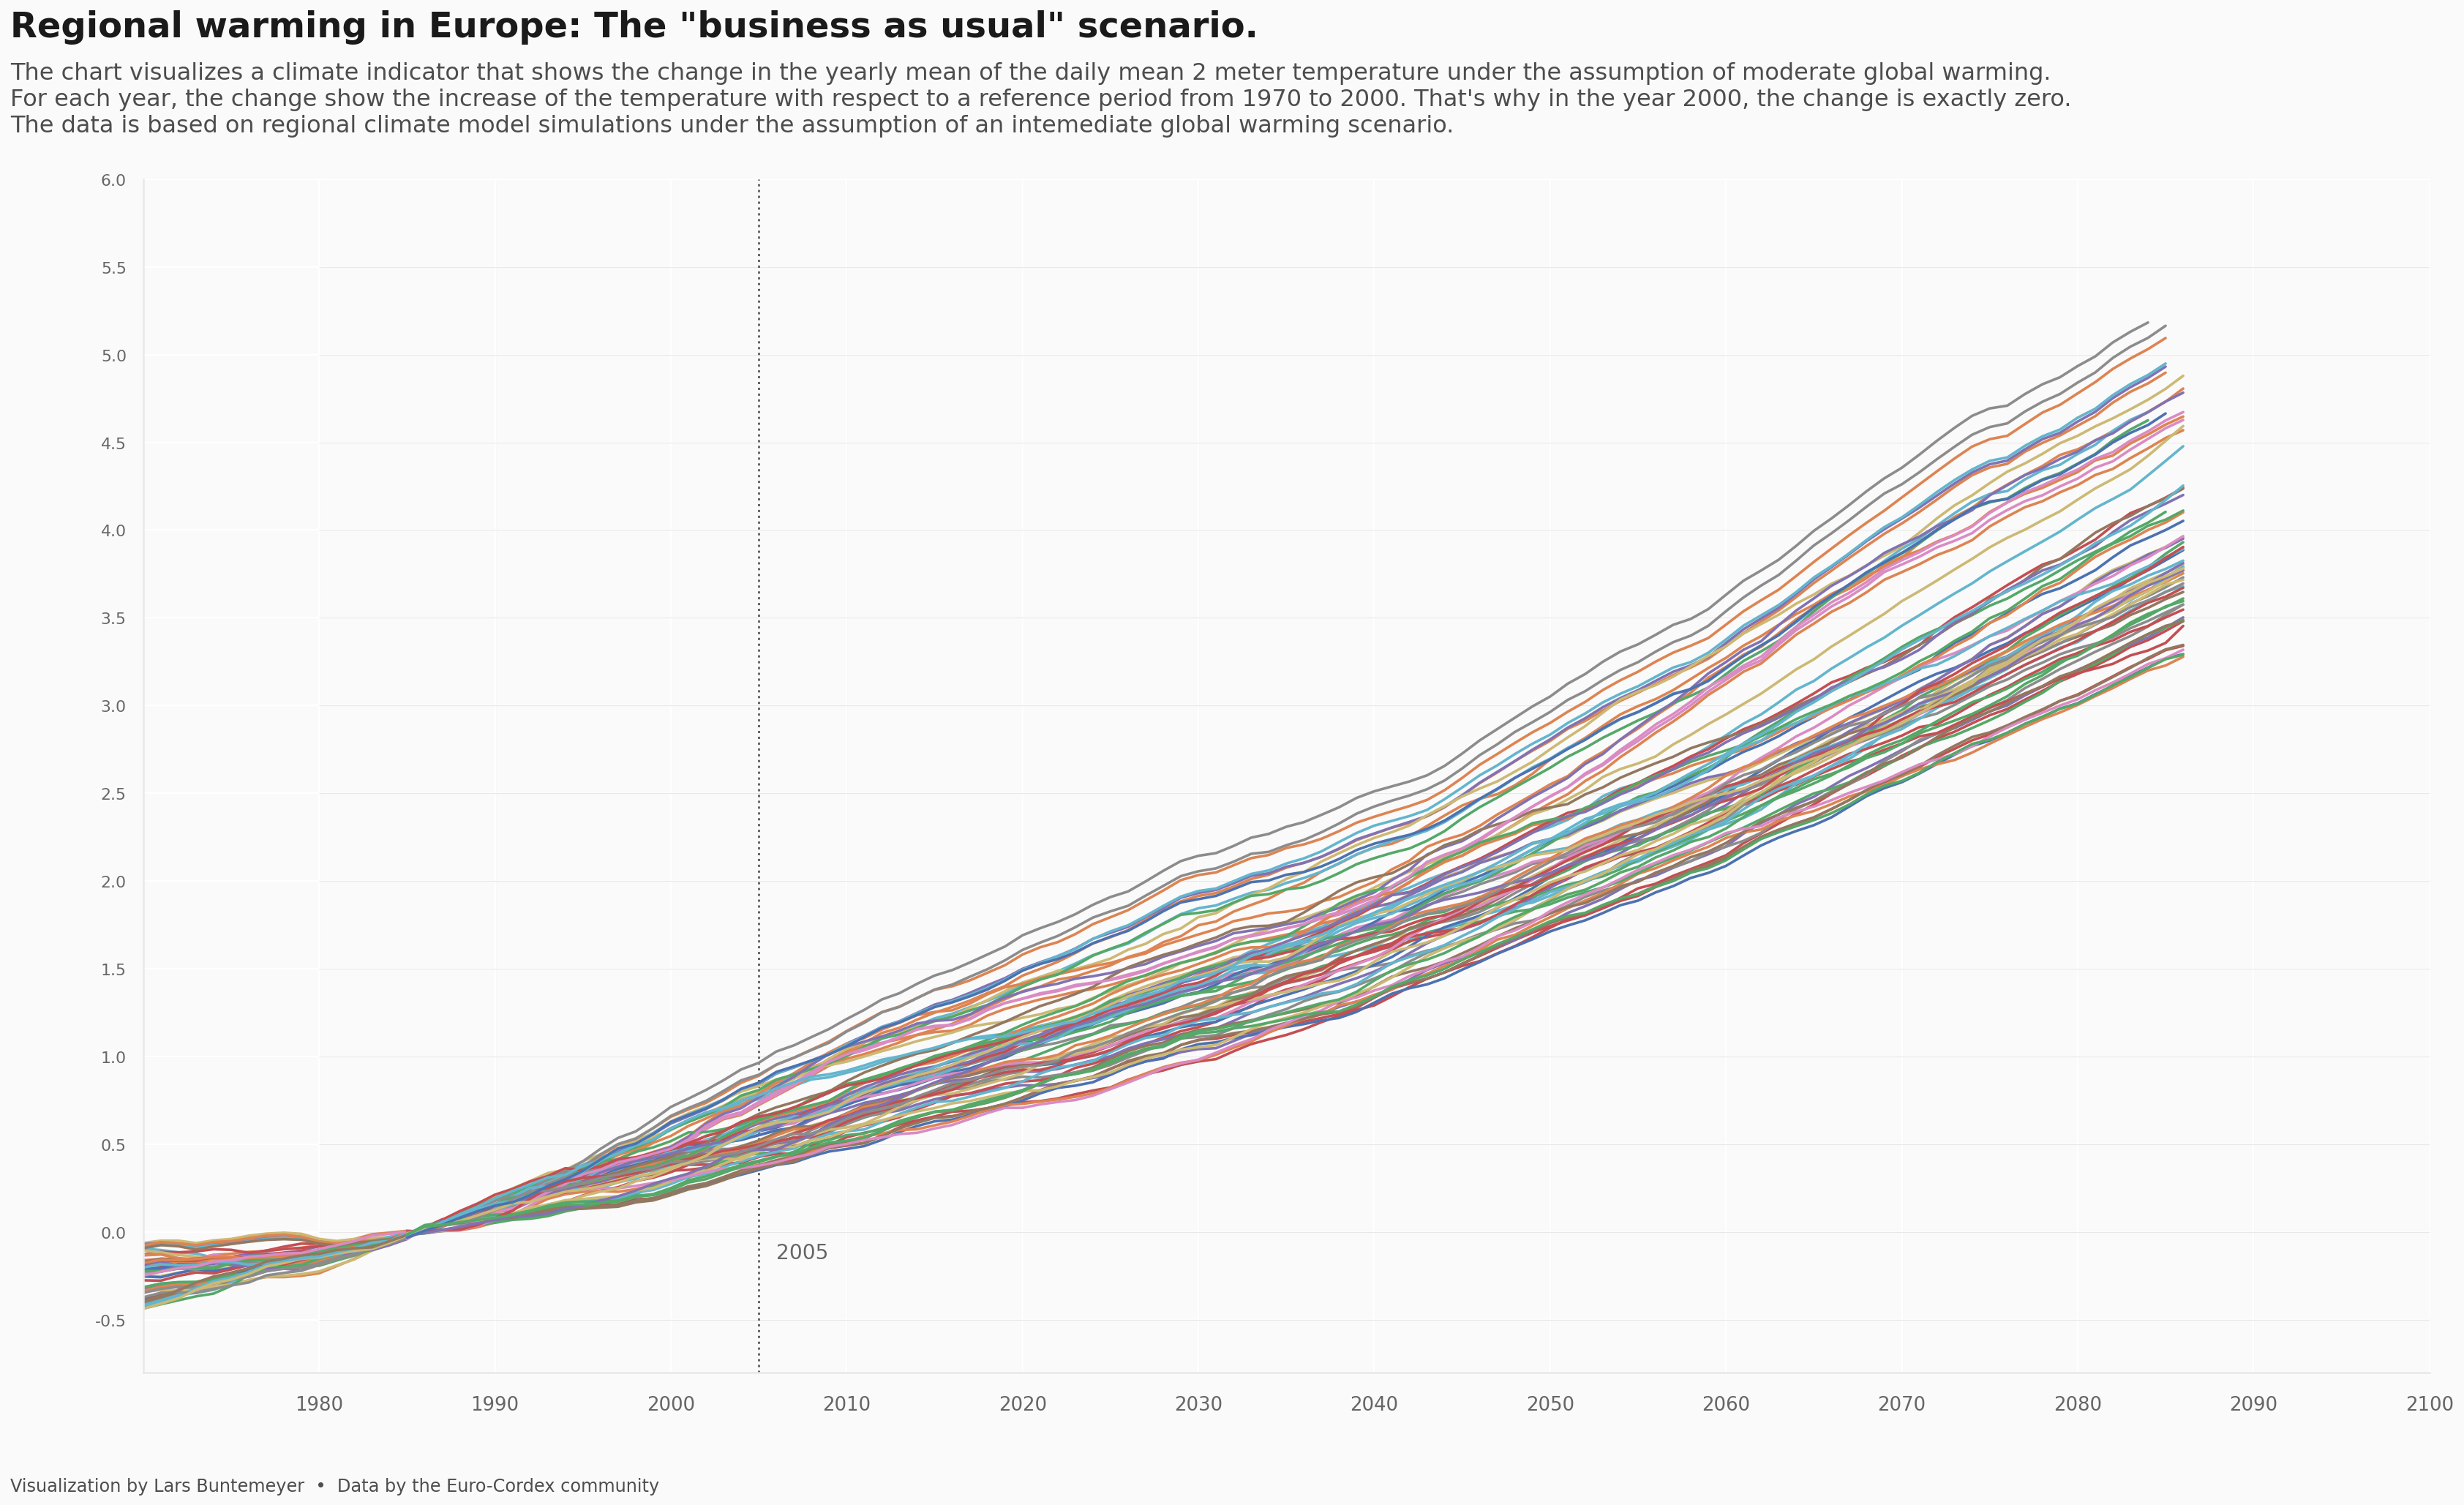

In [142]:
# Customize axes labels and ticks --------------------------------
ax.set_yticks([y for y in np.arange(-0.5, 6.1, 0.5)])
ax.set_yticklabels(
    [f"{y}" for y in np.arange(-0.5, 6.1, 0.5)], 
    fontname="Montserrat", 
    fontsize=11,
    weight=500,
    color=GREY40
)

ax.set_xticks([x for x in np.arange(1980, 2101, 10)])
ax.set_xticklabels(
    [x for x in np.arange(1980, 2101, 10)], 
    fontname= "Montserrat", 
    fontsize=13,
    weight=500,
    color=GREY40
)

# Increase size and change color of axes ticks
ax.tick_params(axis="x", length=12, color=GREY91)
ax.tick_params(axis="y", length=8, color=GREY91)

# Customize spines
ax.spines["left"].set_color(GREY91)
ax.spines["bottom"].set_color(GREY91)
ax.spines["right"].set_color("none")
ax.spines["top"].set_color("none")

# Add titles, subtitles, and caption -----------------------------
# This uses `fig.text()` instead of regular titles to have full
# control of the text alignment.
subtitle = [
    "The chart visualizes a climate indicator that shows the change in the yearly mean of the daily mean 2 meter temperature under the assumption of moderate global warming.",
    "For each year, the change show the increase of the temperature with respect to a reference period from 1970 to 2000. That's why in the year 2000, the change is exactly zero.", 
    "The data is based on regional climate model simulations under the business as usual global warming scenario.", 
]

fig.text(
    0.08,
    0.97,
    "Regional warming in Europe: The \"business as usual\" scenario.",
    color=GREY10,
    fontsize=24,
    fontname="Montserrat",
    weight="bold"
)

fig.text(
    0.08,
    0.91,
    "\n".join(subtitle),
    ha="left",
    color=GREY30,
    fontname="Montserrat",
    fontsize=16,
)

fig.text(
    0.08, 
    0.05, 
    "Visualization by Lars Buntemeyer  •  Data by the Euro-Cordex community", 
    fontname="Montserrat", 
    fontsize=12, 
    color=GREY30, 
    ha="left"
)

fig